# neural machine translation
Here we build a attention based model for translating human-readable (like "25th of April, 2021", etc.) dates to machine readable dates (like "25-04-2021", etc.)

In [1]:
import numpy as np
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch import nn
from matplotlib import pyplot as plt

import os, sys
sys.path.append(os.sep.join(['..','data']))
from loaders.fake_dates import FakeDates

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch using device: {device}")

PyTorch using device: cuda


## # training-data

In [2]:
train_dataset = FakeDates(dataset_size=10000)
test_dataset = FakeDates(dataset_size=1000)

100%|██████████| 10000/10000 [00:00<00:00, 15987.11it/s]


Created a dataset of size: 10000


100%|██████████| 1000/1000 [00:00<00:00, 19422.84it/s]

Created a dataset of size: 1000


## # forward-propagation

> **Note**: for forward propagation equations, read [Section-2, Back-propagation: LSTM](./backprop-lstm.pdf).

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, model_arch: dict, pad_index: int):
        super(EncoderRNN, self).__init__()

        self.model_arch = model_arch
        self.pad_index = pad_index

        self.module_dict = nn.ModuleDict({
            'pre-attn-lstm': nn.LSTM(
                input_size=model_arch['n_x'],
                hidden_size=model_arch['pre-n_a'],
                num_layers=model_arch['pre-L'],
                bias=True,
                batch_first=True,
                bidirectional=True)
        })
    
    def __init_hidden(self, m: int):
        """
        m: the batch-size

        output: the initial hidden-state of zeros, i.e. a zero vector
        """

        return torch.zeros(size=(2 * self.model_arch["pre-L"], 
            m, self.model_arch['pre-n_a'])).to(device=device)

    def __init_cell(self, m: int):
        """
        m: the batch-size

        output: the initial cell-state of zeros, i.e. a zero vector
        """

        return torch.zeros(size=(2 * self.model_arch["pre-L"], 
            m, self.model_arch['pre-n_a'])).to(device=device)

    def forward(self, x: torch.Tensor):
        """
        x: shape -> (m,T_x,n_x)

        output: tuple -> (shape -> (m,T_x,2*pre-n_a), shape -> (m,))
        """
        # shape -> (m,)
        x_seq_lengths = torch.sum(torch.where(
            torch.argmax(input=x, dim=2) != self.pad_index, 1, 0), dim=1)\
                .to(device=torch.device('cpu'))

        # shape -> (m,T_x,n_x)
        X_pp = nn.utils.rnn.pack_padded_sequence(input=x, lengths=x_seq_lengths, 
            batch_first=True, enforce_sorted=False)
        # shape -> ((2,m,pre-n_a), (2,m,pre-n_a))
        pre_ac_0 = (self.__init_hidden(m=len(x)), self.__init_cell(m=len(x))) 
        
        # shape -> (m, T_x, 2 * pre-n_a)
        pre_a, _ = self.module_dict['pre-attn-lstm'](X_pp, pre_ac_0)
        # shape -> ((m, T_x, 2 * pre-n_a), (m,))
        pre_a, a_seq_lengths = nn.utils.rnn.pad_packed_sequence(
            sequence=pre_a, batch_first=True)
        
        assert torch.eq(input=x_seq_lengths, other=a_seq_lengths).sum() == len(x), \
            "Mismatch of input-output pre-attention sequence lengths:" \
                + f"\t-Input: {x_seq_lengths}\n\t-Output: {a_seq_lengths}"

        return pre_a, a_seq_lengths

class Contextualizer(nn.Module):
    def __init__(self, model_arch: dict):
        super(Contextualizer, self).__init__()

        self.model_arch = model_arch

        self.module_dict = nn.ModuleDict({
            'linear-l1': nn.utils.skip_init(nn.Linear,
                in_features=self.model_arch['post-n_a'] + 2 * self.model_arch['pre-n_a'],
                out_features=self.model_arch['ctxt-l1'],
                bias=True),
            'activation-l1': nn.Tanh(),
            'linear-l2': nn.utils.skip_init(nn.Linear, 
                in_features=self.model_arch['ctxt-l1'],
                out_features=self.model_arch['ctxt-l2'],
                bias=True),
            'activation-l2': nn.ReLU(),
            'softmax': nn.Softmax(dim=1)
        })
        nn.init.xavier_uniform_(tensor=self.module_dict['linear-l1'].weight)
        nn.init.zeros_(tensor=self.module_dict['linear-l1'].bias)
        nn.init.xavier_uniform_(tensor=self.module_dict['linear-l2'].weight)
        nn.init.zeros_(tensor=self.module_dict['linear-l2'].bias)

    def forward(self, post_a_prev: torch.Tensor, pre_a: torch.Tensor, 
            seq_lengths: torch.Tensor):
        """
        post_a_prev: shape -> (m, post-n_a)
        pre_a: shape -> (m, T_x, 2 * pre-n_a)
        seq_lengths: shpae -> (m,)

        output: the context vector; shape -> (m, 2*pre-n_a)
        """
        
        # shape -> (m, T_x, post-n_a)
        repeat_post_a = torch.repeat_interleave(
            input=torch.reshape(
                post_a_prev, shape=(post_a_prev.shape[0], 1, post_a_prev.shape[1])), 
            repeats=pre_a.shape[1], dim=1)
        # shape -> (m, T_x, post-n_a + 2 * pre-n_a)
        energies = torch.cat(tensors=[pre_a, repeat_post_a], dim=2)
        
        # shape -> (m, T_x, ctxt-l1)
        energies = self.module_dict['linear-l1'](energies)
        # shape -> (m, T_x, ctxt-l1)
        energies = self.module_dict['activation-l1'](energies)
        # shape -> (m, T_x, ctxt-l2)
        energies = self.module_dict['linear-l2'](energies)
        # shape -> (m, T_x, ctxt-l2)
        energies = self.module_dict['activation-l2'](energies)
        
        # shape -> (m, T_x, 1)
        sftmx_mask = torch.where(
            torch.reshape(
                input=torch.arange(start=0, end=pre_a.shape[1], step=1), 
                shape=(1,-1, 1))
            >= torch.reshape(input=seq_lengths, shape=(-1,1,1)), 
            float('-inf'), float(0)).to(device=device)

        # torch.mul() doesn't work since the zeros (in the mask) will 
        # make the useful energies to zero and the useless energies 
        # become float('-inf')
        # shape -> (m, T_x, ctxt-l2)
        attn_weights = self.module_dict['softmax'](
            torch.add(input=energies, other=sftmx_mask))
        
        # shape -> (m, T_x, 2 * pre-n_a)
        context = torch.mul(input=pre_a, other=attn_weights)
        # shape -> (m, 2 * pre-n_a)
        context = torch.sum(context, dim=1)

        return context

class DecoderRNN(nn.Module):
    def __init__(self, model_arch: dict, pad_index: int):
        super(DecoderRNN, self).__init__()

        self.model_arch = model_arch

        self.module_dict = nn.ModuleDict({
            'encoder-rnn': EncoderRNN(
                model_arch=self.model_arch, 
                pad_index=pad_index),
            'contextualizer': Contextualizer(
                model_arch=self.model_arch),
            'post-lstm-cell': nn.LSTMCell(
                input_size=2*self.model_arch['pre-n_a'],
                hidden_size=self.model_arch['post-n_a'],
                bias=True),
            'linear-l3': nn.utils.skip_init(nn.Linear,
                in_features=self.model_arch['post-n_a'],
                out_features=self.model_arch['n_y'],
                bias=True),
            'log-sftmx': nn.LogSoftmax(dim=1) # TODO: fix this
        })
        nn.init.xavier_uniform_(tensor=self.module_dict['linear-l3'].weight)
        nn.init.zeros_(tensor=self.module_dict['linear-l3'].bias)
    
    def __init_hidden(self, m: int):
        """
        m: the batch-size

        output: the initial hidden-state of zeros, i.e. a zero vector
        """

        return torch.zeros(size=(m, self.model_arch['post-n_a']))\
            .to(device=device)

    def __init_cell(self, m: int):
        """
        m: the batch-size

        output: the initial cell-state of zeros, i.e. a zero vector
        """

        return torch.zeros(size=(m, self.model_arch['post-n_a']))\
            .to(device=device)

    
    def forward(self, x: torch.Tensor):
        """
        x: shape -> (m, T_x, n_x)

        output: y_hat; shape -> (m,n_y,T_y)
        """
        # shape -> ((m,post-n_a), (m,post-n_a))
        post_a_prev, post_c_prev = self.__init_hidden(m=len(x)),\
            self.__init_cell(m=len(x))        
        pre_a, seq_lengths = self.module_dict['encoder-rnn'](x)

        y_hat = list()
        for i in np.arange(start=0, stop=self.model_arch['T_y'], step=1):
            context = self.module_dict['contextualizer'](
                post_a_prev=post_a_prev, pre_a=pre_a, seq_lengths=seq_lengths)
            # shape -> ((m,post-n_a), (m,post-n_a))
            post_a, post_c = self.module_dict['post-lstm-cell'](
                context, (post_a_prev, post_c_prev))
            
            # shape -> (m,n_y)
            z = self.module_dict['linear-l3'](post_a)
            # shape -> (m,n_y)
            y_hat_t = self.module_dict['log-sftmx'](z)
            y_hat.append(y_hat_t)

            # updating hidden and cell states for next iteration
            post_a_prev, post_c_prev = post_a, post_c

        return torch.stack(tensors=y_hat, dim=2)

In [4]:
model_arch = {
    'n_x': len(train_dataset.hvocab_idx), # the input size
    'pre-n_a': 32, # n_a for the pre-attention LSTM
    'pre-L': 1, # number of layers in pre-attention LSTM

    'ctxt-l1': 10, # output space for the first dense layer in context
    'ctxt-l2': 1, # output space for the second dense layer in context

    'post-n_a': 64, # n_a for the post-attention LSTM
    'n_y': len(train_dataset.mvocab_idx),
    'T_y': 10
}
model = DecoderRNN(model_arch=model_arch, pad_index=train_dataset.hvocab_idx[train_dataset.char_pad])
model.to(device=device)
print(model)

DecoderRNN(
  (module_dict): ModuleDict(
    (encoder-rnn): EncoderRNN(
      (module_dict): ModuleDict(
        (pre-attn-lstm): LSTM(37, 32, batch_first=True, bidirectional=True)
      )
    )
    (contextualizer): Contextualizer(
      (module_dict): ModuleDict(
        (linear-l1): Linear(in_features=128, out_features=10, bias=True)
        (activation-l1): Tanh()
        (linear-l2): Linear(in_features=10, out_features=1, bias=True)
        (activation-l2): ReLU()
        (softmax): Softmax(dim=1)
      )
    )
    (post-lstm-cell): LSTMCell(64, 64)
    (linear-l3): Linear(in_features=64, out_features=11, bias=True)
    (log-sftmx): LogSoftmax(dim=1)
  )
)


## # backward-propagation

> **Note**: for backward-propagation equations, read [Section-3](./backprop-lstm.pdf)

In [5]:
def evaluate_model(model: nn.Module, loss_func: nn.Module, test_data: Dataset, 
        batch_size: int, model_arch: dict):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    
    total_test_loss: float = 0
    test_correct_count: int = 0
    
    with torch.no_grad():
        model.eval() # set model in evaluation mode

        for batch, (Xb, Yb) in enumerate(test_loader):
            # movie them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            total_test_loss += (loss.item() * len(Xb) / model_arch["T_y"])
            test_correct_count += \
                ((torch.argmax(pred, dim=1) == Yb).sum().item() / model_arch["T_y"])
    
    return total_test_loss / len(test_data), test_correct_count / len(test_data)

def visualize_training(train_accuracies: list, train_losses: list, 
        test_accuracies: list, test_losses: list):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

    ax1 = axs[0]
    ax1.plot(np.array(train_accuracies) * 100, label="train-accuracy")
    ax1.plot(np.array(test_accuracies) * 100, label="test-accuracy")
    ax1.set_ylabel('accuracy -->')
    ax1.set_xlabel('epoch -->')
    ax1.legend()

    ax2 = axs[1]
    ax2.plot(train_losses, label="train-loss")
    ax2.plot(test_losses, label="test-loss")
    ax2.set_ylabel('loss -->')
    ax2.set_xlabel('epoch -->')
    ax2.legend()

    plt.show()

def learn_model(model_arch: dict, train_data: Dataset, test_data: Dataset, model: nn.Module,
        learning_rate: np.double, beta1: np.double, beta2: np.double, 
        epsilon: np.double, num_epochs: int, batch_size: int, lr_decay_rate: np.double):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    loss_func = nn.NLLLoss(reduction='mean') # compute the mean of the loss
    optimizer = torch.optim.Adam(params=model.parameters(), 
        lr=learning_rate, betas=[beta1, beta2], eps=epsilon)
    lr_schedular = torch.optim.lr_scheduler.LambdaLR(
        optimizer=optimizer, lr_lambda=lambda epoch: learning_rate / (1 + lr_decay_rate * epoch))
    train_losses = list()
    train_accuracies = list()
    test_losses = list()
    test_accuracies = list()

    for e in tqdm(np.arange(start=0, stop=num_epochs, step=1)):
        epochal_train_loss: float = 0.0
        epochal_correct_count: int = 0

        model.train(mode=True)
        for batch, (Xb, Yb) in enumerate(train_loader):
                        # move them to CUDA/CPU device
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb)
            loss = loss_func(pred, Yb) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for debugging
            epochal_train_loss += (loss.item() * len(Xb) / model_arch['T_y'])
            epochal_correct_count += \
                ((torch.argmax(pred, dim=1) == Yb).sum().item() / model_arch['T_y'])

        train_losses.append(epochal_train_loss / len(train_data))
        train_accuracies.append(epochal_correct_count / len(train_data))

        test_loss, test_accuracy = evaluate_model(
            model=model, model_arch=model_arch, test_data=test_data, 
            loss_func=loss_func, batch_size=batch_size)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # updating learning rate
        lr_schedular.step()

    return model, train_losses,\
        train_accuracies, test_losses, test_accuracies

## # training-model

100%|██████████| 400/400 [55:49<00:00,  8.37s/it]


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.048796 



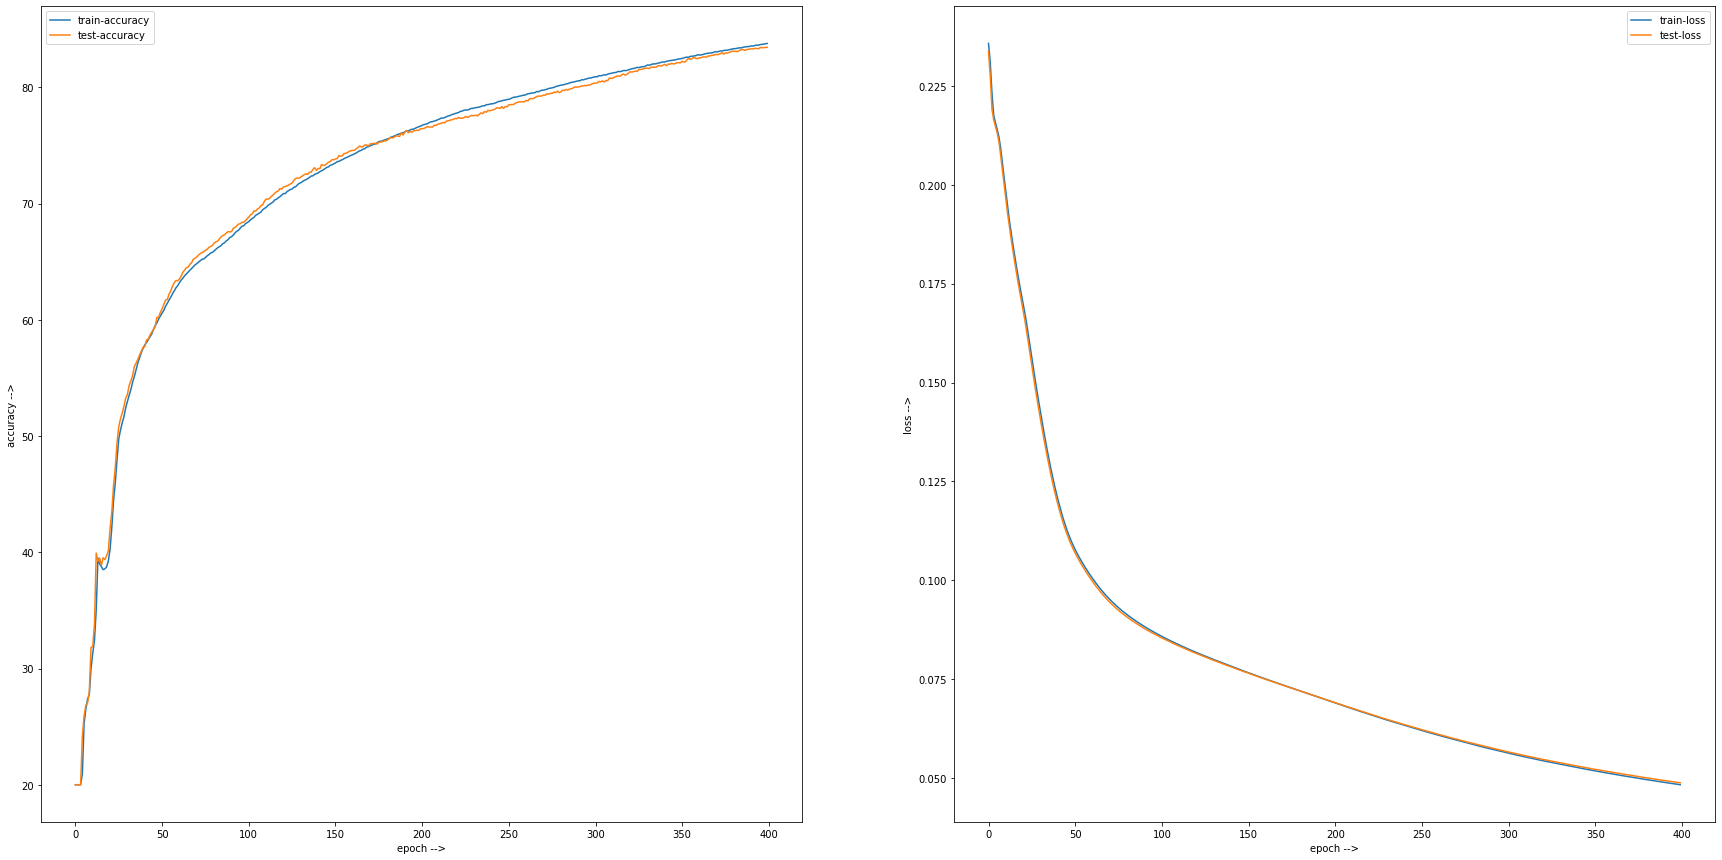

In [6]:
model, train_losses, train_accuracies, test_losses, test_accuracies = learn_model(
    train_data=train_dataset, test_data=test_dataset, model=model, 
    learning_rate=5e-3, beta1=0.9, beta2=0.999, epsilon=1e-08, lr_decay_rate=0.01,
    num_epochs=400, batch_size=64, model_arch=model_arch)

test_loss, test_accuracy = evaluate_model(model=model, test_data=test_dataset, 
    batch_size=64, loss_func=nn.NLLLoss(reduction='mean'), model_arch=model_arch)
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

visualize_training(train_accuracies=train_accuracies, train_losses=train_losses,
    test_accuracies=test_accuracies, test_losses=test_losses)